# **RQ1 Cifar**

## Defining the diversity functions GD (Geometric Diversity), STD and NCD (Normalized Compression Distance)

# **Dataset and Models**

In [10]:

import model_files as model_all
import torch
device = torch.device("cuda:0")
import numpy as np
from tqdm import tqdm
from PIL import Image
# from openTSNE import TSNE
import matplotlib.pyplot as plt
import copy
# import pandas as pd
# import seaborn as sns
import random
import tensorflow as tf
import torch

import torchvision.transforms as transforms

def dataset(arg, model_name):
  if arg=="cifar10":
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    # 定义数据转换：归一化
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
    ])

    # x_test_original = x_test
    # x_test_tensor = torch.stack([transform(image) for image in x_test])
    x_test_original = x_train
    x_test_tensor = torch.stack([transform(image) for image in x_train])

    if model_name=="VGG16_BN":
        ResNet20 = model_all.get_DNN_model('CIFAR10', "VGG16_BN")
        ResNet20.load_state_dict(torch.load("./model_files/CIFAR10/checkpoints/classify_model/VGG16_BN.pt", map_location=device)) # 这个pt文件里不仅仅是参数，包括了模型
        # ResNet50 = torch.load("./model_files/CIFAR10/checkpoints/classify_model/ResNet50.pt", map_location=device)
        ResNet20 = ResNet20.to(device)
        ResNet20.eval()

        feature_model = deepcopy(ResNet20)
        # feature_model.fc = nn.Identity() # 相当于取消fc层, 这样

    # 将数据转移到正确的设备
    x_test_tensor = x_test_tensor.to(device)

    batch_size = 32  # Adjust based on your memory constraints
    features_list = []
    with torch.no_grad():
        for i in range(0, x_test_tensor.size(0), batch_size):
            batch = x_test_tensor[i:i + batch_size]
            features, _ = feature_model.get_features(batch)
            # features= feature_model(batch)
            features_list.append(features.cpu())  # Move to CPU if necessary
    features = torch.cat(features_list, dim=0)
    features = torch.squeeze(features)



  return x_test_original, x_test_tensor, y_train, features

In [11]:
############################################################## Call_functions  ##########################################
import pickle


x_test_original, x_test_tensor, y_test, features= dataset("cifar10", "VGG16_BN")
print("x_test_original.shape", x_test_original.shape)
print("x_test_tensor.shape", x_test_tensor.shape)
print("y_test", y_test.shape)
print("feature.shape", features.shape)


# 假设 x_test_original, x_test_tensor, y_test, features 已经定义并处理好了

# 保存 x_test_original
with open('experiment/x_test_original.pkl', 'wb') as f:
    pickle.dump(x_test_original, f)

# 保存 x_test_tensor
with open('experiment/x_test_tensor.pkl', 'wb') as f:
    pickle.dump(x_test_tensor, f)

# 保存 y_test
with open('experiment/y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

# 保存 features
with open('experiment/features.pkl', 'wb') as f:
    pickle.dump(features, f)

x_test_original.shape (50000, 32, 32, 3)
x_test_tensor.shape torch.Size([50000, 3, 32, 32])
y_test (50000, 1)
feature.shape torch.Size([50000, 512])


In [9]:
import bz2
from copy import deepcopy
import numpy as np
import random
from numpy.random import rand, randn


def NCD_bz(X_data):

  res =0
  Set_comp=[]
  X1=deepcopy(list(X_data))

  NCD1=[]
  for ll in range(len(X_data)) :
    if len(X1)==2: 
      x_y = bytes(X1[0]) + bytes(X1[1])  # compress file 2
      x_y_comp = bz2.compress(x_y)  # compress file concatenated 
      ncd = (len(x_y_comp) - min(len(bz2.compress(bytes(X1[0]))), len(bz2.compress(bytes(X1[1]))))) / \
      max(len(bz2.compress(bytes(X1[0]))), len(bz2.compress(bytes(X1[1]))))
      NCD1.append(ncd)
      break
    Set_comp=[]
    Cx=[]
    for i in range(len(X1)):
      Cx.append(len(bz2.compress(bytes(X1[i]))))
      if i==0:
        sumYk=deepcopy(bytes(X1[i]))
      else:
        sumYk=sumYk+bytes(X1[i])
      # print(Cx)
      # print("i",i)
      X_copy=deepcopy(X1)
      res =0
      for j in X_copy:
        if res==0:
          res = deepcopy(bytes(j))
        else:
          res=res+bytes(j)
      Set_comp.append(len(bz2.compress(res)))
    indexmax=np.argmax(Set_comp)
    maxCk=max(Set_comp)
    minCx=min(Cx)
    NCD1.append((len(bz2.compress(sumYk))-minCx )/maxCk)
    X1.pop(indexmax)
  print("NCD",max(NCD1))
  return max(NCD1)

In [10]:
from numpy import linalg as LA
def STD(x_sample):
  std_f=np.std(x_sample, axis=0)
  L2norm=LA.norm(std_f, 2)
  L1norm=LA.norm(std_f, 1)
  print("shape x- sample", x_sample.shape)
  rrr=np.linalg.matrix_rank(x_sample)
  print("rank of feature matrix", rrr)
  print("L2norm", L2norm)
  print("L1norm", L1norm)
  return L1norm,rrr

In [37]:
# 计算面积的，这个跟几何多样性意义不同。
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull


def GD_(x_sample):
    # 降维到 2 维
    pca = PCA(n_components=2)
    x_reduced = pca.fit_transform(x_sample)
        # 归一化
    scaler = MinMaxScaler()
    x_normalized = scaler.fit_transform(x_reduced)
        # 计算凸包
    hull = ConvexHull(x_normalized)

    # 计算凸包的面积
    area = hull.volume

    print("覆盖范围 (面积):", area)
    return area



In [38]:
from scipy.linalg import lu
from sklearn.preprocessing import StandardScaler

def GD(x_sample):


    epsilon = 0.5
    h=np.dot(x_sample, x_sample.T)+ epsilon * np.eye(x_sample.shape[0])
    # h=np.dot(x_sample, x_sample.T)
    # print(h)
    #     # 创建 MinMaxScaler 对象
    # scaler = MinMaxScaler()
    # # 拟合并转换数据
    # h = scaler.fit_transform(h)

    sign, Ldet=np.linalg.slogdet(h)
    # Ldet=np.linalg.det(h)
    # LU分解
    # P, L, U = lu(h)
    # # 计算行列式
    # Ldet = np.prod(np.diag(U))
    print("Ldet2", Ldet,sign)
    print("size h", h.shape)
    # print("Condition Number:", condition_number)
    return Ldet

In [39]:
def back_process(samples,percent,model,method):
    num = len(samples)
    background_imgs = torch.load('./static/data/CIFAR10/background/background_remove_fore.pt')
    random_image_number = random.sample(range(50000), num)
    background_img = [background_imgs[idx] for idx in random_image_number]

    masks = torch.zeros(num, 3, 32, 32)

    # 创建一个全零的 32x32 的 tensor
    for i in range(num):
        mask = torch.zeros(32, 32)
        mask_size = 8
        # 生成随机的左上角坐标
        start_row = random.randint(0, 32 - mask_size)
        start_col = random.randint(0, 32 - mask_size)
        # 将一个 8x8 的方块设置为 1
        mask[start_row:start_row + mask_size, start_col:start_col + mask_size] = 1

         # Add the mask to the `masks` tensor
        masks[i] = mask.unsqueeze(0).repeat(3, 1, 1)

    # 使用 torch.where() 函数将不包含 CAM 的部分设置为空白
    # 将 binary_cams 中值为 0 的位置的像素设置为 0，其余位置保持不变
    # masked_imgs = torch.where(expanded_binary_cams == 0, torch.tensor(0, device=device), imgs)
    # print(background_img.device,expanded_mask_tensor.device,imgs.device)
    expanded_mask_tensor = masks.to(device)
    samples = torch.stack(samples)

    apply_background_process = torch.rand(num) < percent  # Generate a tensor of random values and check against `percent`

    # Create an output tensor
    output_samples = samples.clone()

    for i in range(num):
        if apply_background_process[i]:
            if(method == "backmix"):
                output_samples[i] = background_img[i] * expanded_mask_tensor[i] + samples[i] * (1 - expanded_mask_tensor[i])

            if(method == "cutout"):
                output_samples[i] =  samples[i] * (1 - expanded_mask_tensor[i])

    # 将数据转移到正确的设备
    output_samples = output_samples.to(device)

    # 提取特征
    with torch.no_grad():  # 禁用梯度计算
        features,_ = model.get_features(output_samples)

    return features

In [44]:
from sklearn.preprocessing import MinMaxScaler

def diversity(size, label, percent = None, model = None, method = None):
    Ldet=0.0

    while Ldet==0.0:
        # 如果percent是None,那就随机在features中取出size个根据y_test标签为label的样本，其中根据label的个数决定每个label取多少样本，就是每个label取size/label个样本，。
        # 如果percent不是None,那就1.随机在features中取出size个根据y_test标签为label的样本，其中根据label的个数决定每个label取多少样本，就是每个label取size/label个样本
        #                       2.其中按照percent的概率选择一批样本进行进一步处理
        num_labels = len(set(label))  # Calculate the number of unique labels
        x_sample = []  # Placeholder: replace with the actual sample selection logic

        if method is None:
            # If `percent` is `None`, evenly select `size/num_labels` samples for each label.
            for lbl in set(label):
                # Filter samples by `lbl` and select `size/num_labels` of them
                samples_for_lbl = [x for x, y in zip(features, y_test) if y == lbl]
                selected_samples = random.sample(samples_for_lbl, size // num_labels)
                x_sample.extend(selected_samples)



        else:
            # If `percent` is not `None`:
            for lbl in set(label):
                # print("现在选择的label:",lbl)
                samples_for_lbl = [x for x, y in zip(x_test_tensor, y_test) if y == lbl]
                selected_samples = random.sample(samples_for_lbl, size // num_labels)
                  # 对selected_samples中的每个样本处理
                samples = back_process(selected_samples,percent,model,method)
                x_sample.extend(samples)

        x_sample = torch.stack(x_sample)  # Stack into a single tensor
        x_sample = torch.squeeze(x_sample)
        x_sample = x_sample.cpu().numpy()

        # 创建 MinMaxScaler 对象
        scaler = MinMaxScaler()
        # 拟合并转换数据
        x_sample_normalized = scaler.fit_transform(x_sample)


        Ldet = GD(x_sample_normalized)
    std_score,rank_num = STD(x_sample_normalized)
    # ncd_score = NCD_bz(x_sample)
    ncd_score = 0
    # return Ldet, std_score, ncd_score,x_sample_normalized
    return  Ldet, std_score, rank_num



In [50]:
import model_files as model_all
import torch
device = torch.device("cuda:0")
import numpy as np
from tqdm import tqdm
from PIL import Image
# from openTSNE import TSNE
import matplotlib.pyplot as plt
import copy
# import pandas as pd
# import seaborn as sns
import random
import tensorflow as tf
import torch

import torchvision.transforms as transforms
import pickle
# 读取 x_test_original
with open('experiment/x_test_original.pkl', 'rb') as f:
    x_test_original = pickle.load(f)

# 读取 x_test_tensor
with open('experiment/x_test_tensor.pkl', 'rb') as f:
    x_test_tensor = pickle.load(f)

# 读取 y_test
with open('experiment/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

# 读取 features
with open('experiment/features.pkl', 'rb') as f:
    features = pickle.load(f)
X_scaled=features

GD_0=[]
GD_1=[]
GD_2=[]
GD_3=[]
GD_4=[]
GD_5=[]

STD_0=[]
STD_1=[]
STD_2=[]
STD_3=[]
STD_4=[]
STD_5=[]


NCD_0=[]
NCD_1=[]
NCD_2=[]
NCD_3=[]
NCD_4=[]
NCD_5=[]

# 100个样本
SIZE=1000
allclasses=[0,1,2,3,4,5,6,7,8,9]
epoch = 10

ResNet20 = model_all.get_DNN_model('CIFAR10', "VGG16_BN")
ResNet20.load_state_dict(torch.load("./model_files/CIFAR10/checkpoints/classify_model/VGG16_BN.pt", map_location=device)) # 这个pt文件里不仅仅是参数，包括了模型
# ResNet50 = torch.load("./model_files/CIFAR10/checkpoints/classify_model/ResNet50.pt", map_location=device)
ResNet20 = ResNet20.to(device)
ResNet20.eval()
feature_model = copy.deepcopy(ResNet20)
# feature_model.fc = nn.Identity() # 相当于取消fc层, 这样
# ------------------------第一组实验随机选择一个-----------------------
#
# R=0
# C_classes=1
# start1= [random.choice(allclasses)]
# # 20次采样
# for i in range(epoch):
#   h = diversity(SIZE, start1, percent = None)
#   GD_0.append(h[0])
#   STD_0.append(h[1])
#   NCD_0.append(h[2])
#   R=R+1
#   print("第", C_classes,"组实验：第",R,"次")
#
# # ------------------------第二组实验，再原来的基础上添加四个，共5个-----------------------
#
# R=0
# C_classes=2
# remaining_classes = [cls for cls in allclasses if cls not in start1]
#
#
# additional_classes = random.sample(remaining_classes, 2)
# start2 = start1 + additional_classes
#
# for i in range(epoch):
#   h = diversity(SIZE, start2, percent = None)
#   GD_1.append(h[0])
#   STD_1.append(h[1])
#   NCD_1.append(h[2])
#   R=R+1
#   print("第", C_classes,"组实验：第",R,"次")

# ------------------------第1组实验，10个-----------------------

R=0
C_classes=0
start3 = allclasses
for i in range(epoch):
  h = diversity(SIZE, start3, percent = None)
  GD_0.append(h[0])
  STD_0.append(h[1])
  NCD_0.append(h[2])
  R=R+1
  print("第", C_classes,"组实验：第",R,"次")

# ------------------------第2组实验，10个类别，百分之25进行backmix-----------------------

R=0
C_classes=1
start4 = allclasses
percent = 0.25
for i in range(epoch):
  h = diversity(SIZE, start4, percent = percent,model = feature_model, method = "backmix")
  GD_1.append(h[0])
  STD_1.append(h[1])
  NCD_1.append(h[2])
  R=R+1
  print("第", C_classes,"组实验：第",R,"次")
# ------------------------第3组实验，10个类别，百分之50进行backmix-----------------------

R=0
C_classes=2
start5 = allclasses
percent = 0.5
for i in range(epoch):
  h = diversity(SIZE, start5, percent = percent, model = feature_model, method = "backmix")
  GD_2.append(h[0])
  STD_2.append(h[1])
  NCD_2.append(h[2])
  R=R+1
  print("第", C_classes,"组实验：第",R,"次")

# ------------------------第四组实验，10个类别，百分之五十进行backmix-----------------------

R=0
C_classes=3
start4 = allclasses
percent = 0.75
for i in range(epoch):
  h = diversity(SIZE, start4, percent = percent,model = feature_model, method = "backmix")
  GD_3.append(h[0])
  STD_3.append(h[1])
  NCD_3.append(h[2])
  R=R+1
  print("第", C_classes,"组实验：第",R,"次")
# ------------------------第5组实验，10个类别，百分之75进行backmix-----------------------

R=0
C_classes=4
start5 = allclasses
percent = 1
for i in range(epoch):
  h = diversity(SIZE, start5, percent = percent, model = feature_model, method = "backmix")
  GD_4.append(h[0])
  STD_4.append(h[1])
  NCD_4.append(h[2])
  R=R+1
  print("第", C_classes,"组实验：第",R,"次")

# ------------------------第6组实验，10个类别，百分之百进行cutmix-----------------------


# R=0
# C_classes=5
# start5 = allclasses
# percent = 1
# for i in range(5):
#   h = diversity(SIZE, start5, percent = percent, model = feature_model,method = "cutout")
#   GD_4.append(h[0])
#   STD_4.append(h[1])
#   NCD_4.append(h[2])
#   R=R+1
#   print("第", C_classes,"组实验：第",R,"次")


Ldet2 145.9065349106648 1.0
size h (1000, 1000)
shape x- sample (1000, 512)
rank of feature matrix 422
L2norm 6.4547567
L1norm 145.0067
第 0 组实验：第 1 次
Ldet2 146.47328130493162 1.0
size h (1000, 1000)
shape x- sample (1000, 512)
rank of feature matrix 425
L2norm 6.4648705
L1norm 145.16528
第 0 组实验：第 2 次
Ldet2 146.8240374350171 1.0
size h (1000, 1000)
shape x- sample (1000, 512)
rank of feature matrix 425
L2norm 6.454311
L1norm 144.966
第 0 组实验：第 3 次
Ldet2 146.84936480520497 1.0
size h (1000, 1000)
shape x- sample (1000, 512)
rank of feature matrix 425
L2norm 6.5107346
L1norm 146.3049
第 0 组实验：第 4 次
Ldet2 147.3008200869854 1.0
size h (1000, 1000)
shape x- sample (1000, 512)
rank of feature matrix 422
L2norm 6.5315833
L1norm 146.78804
第 0 组实验：第 5 次
Ldet2 145.4633555970536 1.0
size h (1000, 1000)
shape x- sample (1000, 512)
rank of feature matrix 420
L2norm 6.59511
L1norm 148.27905
第 0 组实验：第 6 次
Ldet2 146.24094880849904 1.0
size h (1000, 1000)
shape x- sample (1000, 512)
rank of feature matrix

In [51]:
# Prepare data for each CSV file
import pandas as pd
np.save('experiment/result_1000/GD_0.npy', np.array(GD_0))
np.save('experiment/result_1000/GD_1.npy', np.array(GD_1))
np.save('experiment/result_1000/GD_2.npy', np.array(GD_2))
np.save('experiment/result_1000/GD_3.npy', np.array(GD_3))
np.save('experiment/result_1000/GD_4.npy', np.array(GD_4))
np.save('experiment/result_1000/STD_0.npy', np.array(STD_0))
np.save('experiment/result_1000/STD_1.npy', np.array(STD_1))
np.save('experiment/result_1000/STD_2.npy', np.array(STD_2))
np.save('experiment/result_1000/STD_3.npy', np.array(STD_3))
np.save('experiment/result_1000/STD_4.npy', np.array(STD_4))
np.save('experiment/result_1000/Rank_0.npy', np.array(NCD_0))
np.save('experiment/result_1000/Rank_1.npy', np.array(NCD_1))
np.save('experiment/result_1000/Rank_2.npy', np.array(NCD_2))
np.save('experiment/result_1000/Rank_3.npy', np.array(NCD_3))
np.save('experiment/result_1000/Rank_4.npy', np.array(NCD_4))


In [52]:
import numpy as np
GD_0=np.load('experiment/result_1000/GD_0.npy')
GD_1=np.load('experiment/result_1000/GD_1.npy')
GD_2=np.load('experiment/result_1000/GD_2.npy')
GD_3=np.load('experiment/result_1000/GD_3.npy')
GD_4=np.load('experiment/result_1000/GD_4.npy')


STD_0=np.load('experiment/result_1000/STD_0.npy')
STD_1=np.load('experiment/result_1000/STD_1.npy')
STD_2=np.load('experiment/result_1000/STD_2.npy')
STD_3=np.load('experiment/result_1000/STD_3.npy')
STD_4=np.load('experiment/result_1000/STD_4.npy')


Rank_0=np.load('experiment/result_1000/Rank_0.npy')
Rank_1=np.load('experiment/result_1000/Rank_1.npy')
Rank_2=np.load('experiment/result_1000/Rank_2.npy')
Rank_3=np.load('experiment/result_1000/Rank_3.npy')
Rank_4=np.load('experiment/result_1000/Rank_4.npy')



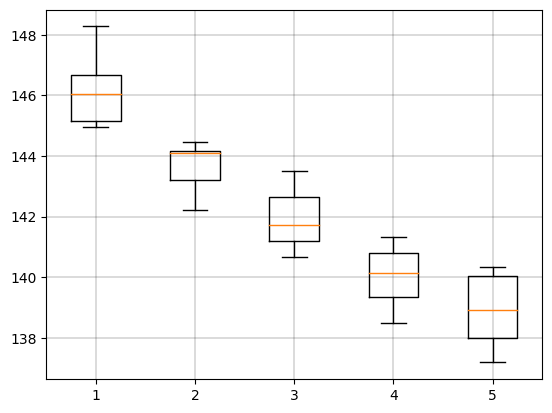

In [53]:

import matplotlib.pyplot as plt
import pandas as pd
  
dataGD_R1 = {'1': np.array(GD_0).tolist(),'2': np.array(GD_1).tolist(),'3': np.array(GD_2).tolist(),'4': np.array(GD_3).tolist(),'5': np.array(GD_4).tolist()}
dataSTD_R1= {'1': np.array(STD_0).tolist(),'2': np.array(STD_1).tolist(),'3': np.array(STD_2).tolist(),'4': np.array(STD_3).tolist(),'5': np.array(STD_4).tolist()}
dataRank_R1= {'1': np.array(Rank_0).tolist(),'2': np.array(Rank_1).tolist(),'3': np.array(Rank_2).tolist(),'4': np.array(Rank_3).tolist(),'5': np.array(Rank_4).tolist()}
plt.figure()
plt.grid(color='black', linestyle='-', linewidth=0.2)
plt.boxplot(dataSTD_R1.values())
plt.xticks(range(1, len(dataSTD_R1.keys()) + 1), dataSTD_R1.keys())
plt.show()

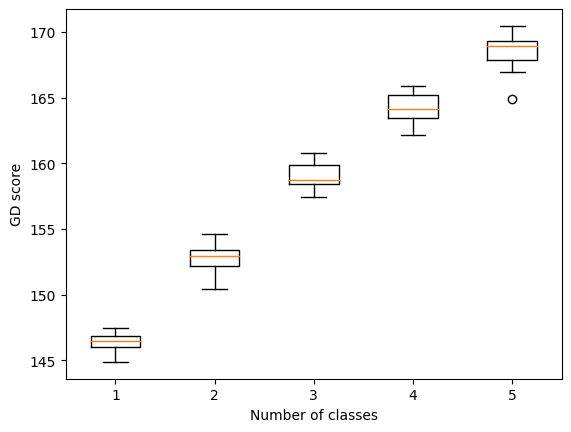

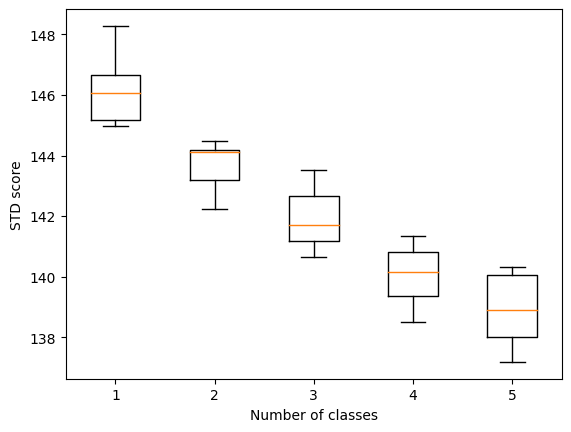

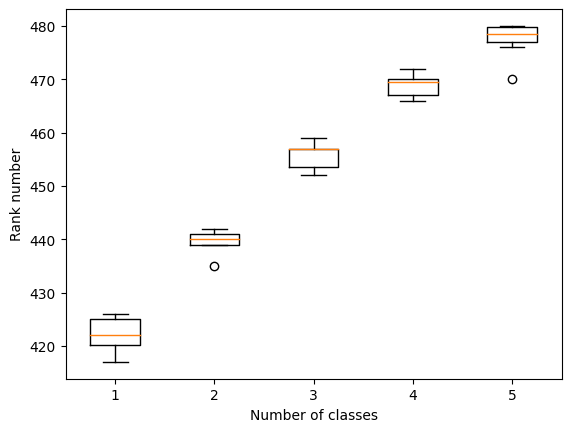

In [54]:
import matplotlib.pyplot as plt
for i in [dataGD_R1,dataSTD_R1,dataRank_R1 ]:
  plt.boxplot(i.values())
  plt.xticks([1,2,3,4,5], [1,2,3,4,5])
  # plt.title("Cifar-10")
  plt.xlabel("Number of classes")
  plt.grid(color='black', linestyle='', linewidth=0.2)
  if i==dataGD_R1:
    # plt.yticks([900,950,1000,1050,1100,1150,1200,1250])
    plt.ylabel("GD score")
    plt.savefig('experiment/result_1000/R1_GD_C3.pdf', bbox_inches='tight')
    plt.show()
  if i==dataSTD_R1:
    plt.ylabel("STD score")
    plt.savefig('experiment/result_1000/R1_STD_C3.pdf', bbox_inches='tight')
    plt.show()
  if i==dataRank_R1:
    plt.ylabel("Rank number")
    plt.savefig('experiment/result_1000/R1_Rank_C3.pdf', bbox_inches='tight')
    plt.show()

# **RQ1 MNIST**

In [ ]:
import bz2
from copy import deepcopy
import numpy as np

# X_data=[x,y,z,f]
def NCD_bz(X_data):

  res =0
  Set_comp=[]
  X1=deepcopy(list(X_data))
  # print("len",len(X1))
  NCD1=[]
  for ll in range(len(X_data)) :
    # print("len Yk",len(X1))
    if len(X1)==2: 
      x_y = bytes(X1[0]) + bytes(X1[1])  # compress file 2
      x_y_comp = bz2.compress(x_y)  # compress file concatenated 
      ncd = (len(x_y_comp) - min(len(bz2.compress(bytes(X1[0]))), len(bz2.compress(bytes(X1[1]))))) / \
      max(len(bz2.compress(bytes(X1[0]))), len(bz2.compress(bytes(X1[1]))))
      NCD1.append(ncd)
      break
    Set_comp=[]
    Cx=[]
    for i in range(len(X1)):
      Cx.append(len(bz2.compress(bytes(X1[i]))))
      if i==0:
        sumYk=deepcopy(bytes(X1[i]))
      else:
        sumYk=sumYk+bytes(X1[i])
      # print(Cx)
      # print("i",i)
      X_copy=deepcopy(X1)
      # print(len(X_copy.pop(i)))
      # print("len",len(X_copy))
      res =0
      for j in X_copy:
        if res==0:
          res = deepcopy(bytes(j))
        else:
          res=res+bytes(j)
      Set_comp.append(len(bz2.compress(res)))
    indexmax=np.argmax(Set_comp)
    maxCk=max(Set_comp)
    minCx=min(Cx)
    NCD1.append((len(bz2.compress(sumYk))-minCx )/maxCk)
    X1.pop(indexmax)
  return max(NCD1)

In [ ]:

X_scaled=np.load("/content/drive/MyDrive/Extracted Features/MNIST/block5_conv3_3*3*512.npy")

model=load_model("/content/drive/MyDrive/sadl11/model/model_mnist_LeNet5.h5")

In [ ]:


import numpy as np
import time
import argparse

from tqdm import tqdm
from keras.datasets import mnist, cifar10
from keras.models import load_model, Model

CLIP_MIN = -0.5
CLIP_MAX = 0.5

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
x_train = x_train.astype("float32")
x_train = (x_train / 255.0) - (1.0 - CLIP_MAX)
x_test = x_test.astype("float32")
x_test = (x_test / 255.0) - (1.0 - CLIP_MAX)

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
import copy
def RQ1_new(size,label,subset):
  if (subset==None):
    Ldet=0.0
    determinant=0.0
    tt=0
    while (Ldet==0.0):
      k=0
      random_sample=[]
      kk=np.argwhere(y_test==label)
      sh=kk.shape
      kk=kk.reshape(sh[0])
      kk=set(kk)
      random_s=random.sample(kk,size)
      print(random_s)
      x_sample = np.zeros((SIZE,4608))
      conv_output=X_scaled
      print("sample", x_sample.shape)
      i=0
      print("Random_indexes",random_s)
      
      random_sample=copy.deepcopy(random_s)
      random_sample.sort()
      for L in random_sample :
        x_sample[i,:]=conv_output[L,:]
        i=i+1

      #diversity score
      h=np.dot(x_sample,x_sample.T)
      sign, Ldet=np.linalg.slogdet(h)
      print("Ldet2", Ldet, sign)
      print("size h", h.shape)
      print("tt",tt)
      tt=tt+1
    std_score=STD(x_sample)
    ncd_score=NCD_bz(x_sample)
  else:
    Ldet=0.0
    determinant=0.0
    tt=0
    while (Ldet==0.0):
      k=0
      random_sample=[]
      kk=np.argwhere(y_test==label)
      sh=kk.shape
      kk=kk.reshape(sh[0])
      kk=set(kk)
      Random_indexes=random.sample(kk,size)
      print(Random_indexes)
      x_sample = np.zeros((SIZE,4608))
      conv_output=X_scaled
      print("sample", x_sample.shape)
      i=0
      # print("Random_indexes",Random_indexes)
      random_s=list(subset)+list(Random_indexes)
      print("Random_indexes",random_s)
      print("len",len(random_s))
      random_sample=copy.deepcopy(random_s)
      random_sample.sort()
      # P = np.zeros((size,32,32,3))
      for L in random_sample :
        x_sample[i,:]=conv_output[L,:]
        # P[i]=x_test[L,:,:,:]
        # yt[i]=y_test[L]
        i=i+1

      #diversity score
      h=np.dot(x_sample,x_sample.T)
      sign, Ldet=np.linalg.slogdet(h)
      print("Ldet2", Ldet, sign)
      print("size h", h.shape)
      print("tt",tt)
      tt=tt+1
    #remove yy=0
    # yy=0
    std_score=STD(x_sample)
    ncd_score=NCD_bz(x_sample)
  return Ldet , std_score , ncd_score


In [ ]:
from numpy import linalg as LA
def STD(x_sample):
  std_f=np.std(x_sample, axis=0)
  L2norm=LA.norm(std_f, 2)
  L1norm=LA.norm(std_f, 1)
  print("shape x- sample", x_sample.shape)
  rrr=np.linalg.matrix_rank(x_sample)
  print("rank of feature matrix", rrr)
  print("L2norm", L2norm)
  print("L1norm", L1norm)
  return L1norm

In [ ]:
GD_0=[]
GD_1=[]
GD_2=[]
GD_3=[]


STD_0=[]
STD_1=[]
STD_2=[]
STD_3=[]



NCD_0=[]
NCD_1=[]
NCD_2=[]
NCD_3=[]


SIZE=100
# for start1 in range(10):
allclasses=[0,1,2,3,4,5,6,7,8,9]
start1=1
c2=0
c3=6
c4=2
c5=8
c6=9
c7=4
c8=7
c9=3
c10=5
R=0

C_classes=1
for i in range(20):
  h=RQ1_new(SIZE,start1 , None)
  GD_0.append(h[0])
  STD_0.append(h[1])
  NCD_0.append(h[2])
  R=R+1
R=0
C_classes=2
allclasses.remove(start1)
# c2=random.choice(allclasses)
# c2=6
for i in range(20):
  subset= np.load("/content/drive/MyDrive/RQ1new/GD_MNIST/Index_"+str(start1)+"_"+str(C_classes-1)+"classes_"+str(R)+".npy")
  subset=list(subset)
  new=len(subset)//2
  new_list= list(subset[:new])
  h=RQ1_new(SIZE-(len(new_list)),c2 , new_list)
  GD_1.append(h[0])
  STD_1.append(h[1])
  NCD_1.append(h[2])
  R=R+1
R=0
C_classes=3
allclasses.remove(c2)
# c3=random.choice(allclasses)
# c3=8
for i in range(20):
  subset= np.load("/content/drive/MyDrive/RQ1new/GD_MNIST/Index_"+str(c2)+"_"+str(C_classes-1)+"classes_"+str(R)+".npy")
  subset=list(subset)
  new_list= list(subset[:33]) + list(subset[33:33+33])
  h=RQ1_new(SIZE-(len(new_list)),c3 , new_list)
  GD_2.append(h[0])
  STD_2.append(h[1])
  NCD_2.append(h[2])
  R=R+1

R=0
C_classes=4
# all
# allclasses.remove(c3)
c4=random.choice(allclasses)
c4=7
for i in range(20):
  subset= np.load("/content/drive/MyDrive/RQ1new/GD_MNIST/Index_"+str(c3)+"_"+str(C_classes-1)+"classes_"+str(R)+".npy")
  subset=list(subset)
  last=len(subset)//3
  new=len(subset)//4
  new_list= list(subset[:25]) + list(subset[33:33+25]) + list(subset[33+34:25+(33+34)])
  h=RQ1_new(SIZE-(len(new_list)),c4 , new_list)
  GD_3.append(h[0])
  STD_3.append(h[1])
  NCD_3.append(h[2])
  R=R+1

In [ ]:

GD_4=[]
GD_5=[]
GD_6=[]
GD_7=[]
GD_8=[]
GD_9=[]
STD_4=[]
STD_5=[]
STD_6=[]
STD_7=[]
STD_8=[]
STD_9=[]
NCD_4=[]
NCD_5=[]
NCD_6=[]
NCD_7=[]
NCD_8=[]
NCD_9=[]

SIZE=100

start1=1
c2=0
c3=6
c4=2
c5=8
c6=9
c7=4
c8=7
c9=3
c10=5


R=0
C_classes=5
# allclasses.remove(c4)

# c5=2
for i in range(20):
  subset= np.load("/content/drive/MyDrive/RQ1new/GD_MNIST/Index_"+str(c4)+"_"+str(C_classes-1)+"classes_"+str(R)+".npy")
  subset=list(subset)
  last=len(subset)//4
  new=len(subset)//5
  new_list= list(subset[:20]) + list(subset[25:20+25]) + list(subset[25*2:20+(25*2)]) + list(subset[25*3:20+(25*3)])
  h=RQ1_new(SIZE-(len(new_list)),c5 , new_list)
  GD_4.append(h[0])
  STD_4.append(h[1])
  NCD_4.append(h[2])
  R=R+1
R=0
C_classes=6
# allclasses.remove(c5)
# c6=0
for i in range(20):
  subset= np.load("/content/drive/MyDrive/RQ1new/GD_MNIST/Index_"+str(c5)+"_"+str(C_classes-1)+"classes_"+str(R)+".npy")
  subset=list(subset)
  last=len(subset)//5
  new=len(subset)//6
  print("newwwwwwwwwwwww",new)
  new_list= list(subset[:16]) + list(subset[20:16+20]) + list(subset[40:17+40]) + list(subset[60:17+60])+ list(subset[80:17+80])
  print(")))))))))))))))))))))))))))))))))))))))))))))))))))))))))))",SIZE-(len(new_list)))
  h=RQ1_new(SIZE-(len(new_list)),c6 , new_list)
  GD_5.append(h[0])
  STD_5.append(h[1])
  NCD_5.append(h[2])
  R=R+1



R=0
C_classes=7
# allclasses.remove(c6)

# c7=3
for i in range(20):
  subset= np.load("/content/drive/MyDrive/RQ1new/GD_MNIST/Index_"+str(c6)+"_"+str(C_classes-1)+"classes_"+str(R)+".npy")
  subset=list(subset)
  last=len(subset)//6
  new=len(subset)//7
  new_list= list(subset[:14]) + list(subset[16:14+16]) + list(subset[16*2:14+(16*2)]) + list(subset[17+16*2:14+(17+16*2)])+ list(subset[17*2+16*2:14+(17*2+16*2)])+list(subset[17*3+16*2:15+(17*3+16*2)])
  h=RQ1_new(SIZE-(len(new_list)),c7 , new_list)
  GD_6.append(h[0])
  STD_6.append(h[1])
  NCD_6.append(h[2])
  R=R+1
R=0
C_classes=8
# allclasses.remove(c7)
# c8=1
for i in range(20):
  subset= np.load("/content/drive/MyDrive/RQ1new/GD_MNIST/Index_"+str(c7)+"_"+str(C_classes-1)+"classes_"+str(R)+".npy")
  subset=list(subset)
  last=len(subset)//7
  new=len(subset)//8

  new_list= list(subset[:12]) + list(subset[14:12+14]) + list(subset[14*2:12+(14*2)]) + list(subset[14*3:12+(14*3)])+ list(subset[14*4:13+(14*4)])+list(subset[14*5:13+(14*5)])+list(subset[14*5+15:13+(14*5+15)])
  h=RQ1_new(SIZE-(len(new_list)),c8 , new_list)
  GD_7.append(h[0])
  STD_7.append(h[1])
  NCD_7.append(h[2])
  R=R+1
R=0
C_classes=9
# allclasses.remove(c8)
# c9=5

for i in range(20):
  subset= np.load("/content/drive/MyDrive/RQ1new/GD_MNIST/Index_"+str(c8)+"_"+str(C_classes-1)+"classes_"+str(R)+".npy")
  subset=list(subset)
  last=len(subset)//8
  new=len(subset)//9
  new_list= list(subset[:11]) + list(subset[12:12+11]) + list(subset[12*2:11+(12*2)]) + list(subset[12*3:11+(12*3)])+ list(subset[12*4:11+(12*4)])+list(subset[12*4+13:11+(12*4+13)])+list(subset[12*4+13*2:11+(12*4+13*2)])+ list(subset[12*4+13*3:11+(12*4+13*3)])
  h=RQ1_new(SIZE-(len(new_list)),c9 , new_list)
  GD_8.append(h[0])
  STD_8.append(h[1])
  NCD_8.append(h[2])
  R=R+1
np.save("/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/NCD_8",NCD_8)
np.save("/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/STD_8",STD_8)
np.save("/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/GD_8",GD_8)
R=0
C_classes=10
# allclasses.remove(c9)
# c10=9
for i in range(20):
  subset= np.load("/content/drive/MyDrive/RQ1new/GD_MNIST/Index_"+str(c9)+"_"+str(C_classes-1)+"classes_"+str(R)+".npy")
  subset=list(subset)
  last=len(subset)//9
  new=len(subset)//10
  new_list= list(subset[:10]) + list(subset[11:11+10]) + list(subset[11*2:10+(11*2)]) + list(subset[11*3:10+(11*3)])+ list(subset[11*4:10+(11*4)])+list(subset[11*5:10+(11*5)])+list(subset[11*6:10+(11*6)])+ list(subset[11*7:10+(11*7)])+list(subset[11*8:10+(11*8)])
  h=RQ1_new(SIZE-(len(new_list)),c10 , new_list)
  GD_9.append(h[0])
  STD_9.append(h[1])
  NCD_9.append(h[2])
  R=R+1

In [ ]:
import numpy as np
GD_0=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/GD_0.npy')
GD_1=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/GD_1.npy')
GD_2=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/GD_2.npy')
GD_3=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/GD_3.npy')
GD_4=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/GD_4.npy')
GD_5=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/GD_5.npy')
GD_6=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/GD_6.npy')
GD_7=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/GD_7.npy')
GD_8=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/GD_8.npy')
GD_9=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/GD_9.npy')

STD_0=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/STD_0.npy')
STD_1=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/STD_1.npy')
STD_2=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/STD_2.npy')
STD_3=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/STD_3.npy')
STD_4=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/STD_4.npy')
STD_5=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/STD_5.npy')
STD_6=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/STD_6.npy')
STD_7=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/STD_7.npy')
STD_8=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/STD_8.npy')
STD_9=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/STD_9.npy')

NCD_0=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/NCD_0.npy')
NCD_1=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/NCD_1.npy')
NCD_2=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/NCD_2.npy')
NCD_3=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/NCD_3.npy')
NCD_4=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/NCD_4.npy')
NCD_5=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/NCD_5.npy')
NCD_6=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/NCD_6.npy')
NCD_7=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/NCD_7.npy')
NCD_8=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/NCD_8.npy')
NCD_9=np.load('/content/drive/MyDrive/RQ1new/GD_MNIST/metrics/NCD_9.npy')







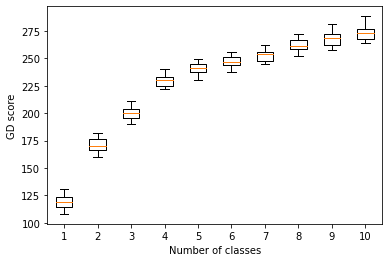

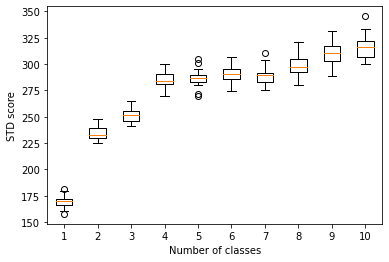

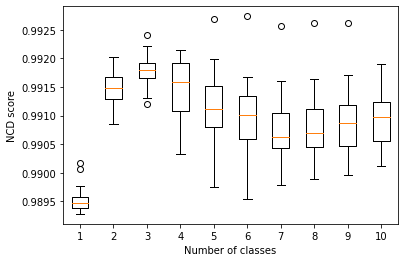

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd
  
dataGD_R1 = {'1': np.array(GD_0).tolist(),'2': np.array(GD_1).tolist(),'3': np.array(GD_2).tolist(),'4': np.array(GD_3).tolist(),'5': np.array(GD_4).tolist(),'6': np.array(GD_5).tolist(),'7': np.array(GD_6).tolist(),'8': np.array(GD_7).tolist(),'9': np.array(GD_8).tolist(),'10': np.array(GD_9).tolist()}
dataSTD_R1= {'1': np.array(STD_0).tolist(),'2': np.array(STD_1).tolist(),'3': np.array(STD_2).tolist(),'4': np.array(STD_3).tolist(),'5': np.array(STD_4).tolist(),'6': np.array(STD_5).tolist(),'7': np.array(STD_6).tolist(),'8': np.array(STD_7).tolist(),'9': np.array(STD_8).tolist(),'10': np.array(STD_9).tolist()}
dataNCD_R1= {'1': np.array(NCD_0).tolist(),'2': np.array(NCD_1).tolist(),'3': np.array(NCD_2).tolist(),'4': np.array(NCD_3).tolist(),'5': np.array(NCD_4).tolist(),'6': np.array(NCD_5).tolist(),'7': np.array(NCD_6).tolist(),'8': np.array(NCD_7).tolist(),'9': np.array(NCD_8).tolist(),'10': np.array(NCD_9).tolist()}



import matplotlib.pyplot as plt
for i in [dataGD_R1,dataSTD_R1,dataNCD_R1 ]:
  plt.boxplot(i.values())
  plt.xticks([1,2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10])
  # plt.title("RQ1")
  plt.xlabel("Number of classes")
  plt.grid(color='black', linestyle='', linewidth=0.2)
  
  if i==dataGD_R1:
    # plt.yticks([900,950,1000,1050,1100,1150,1200,1250])
    plt.ylabel("GD score")
    plt.savefig('/content/drive/MyDrive/RQ1new/GD_MNIST/fig/R1_GD_M2.pdf',bbox_inches='tight')
    plt.show()
  if i==dataSTD_R1:
    plt.ylabel("STD score")
    plt.savefig('/content/drive/MyDrive/RQ1new/GD_MNIST/fig/R1_STD_M2.pdf',bbox_inches='tight')
    plt.show()
  if i==dataNCD_R1:
    plt.ylabel("NCD score")
    plt.savefig('/content/drive/MyDrive/RQ1new/GD_MNIST/fig/R1_NCD_M2.pdf', bbox_inches='tight')
    plt.show()

  